# [データの増強](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ja)

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

num_classes = metadata.features['label'].num_classes
print(num_classes)

5


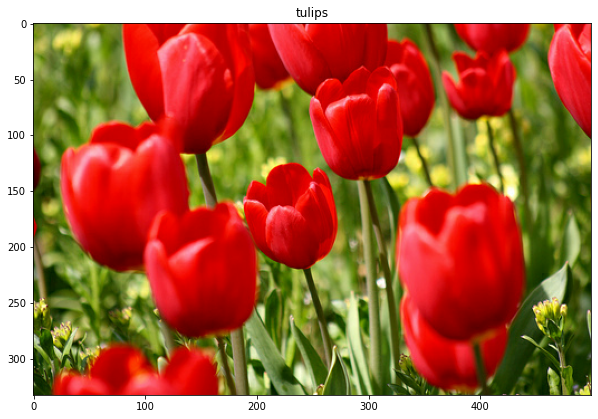

In [24]:
fig = plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    plt.imshow(images.numpy().astype('uint8'))
    plt.title(metadata.features['label'].int2str(labels))

# Preprocessing

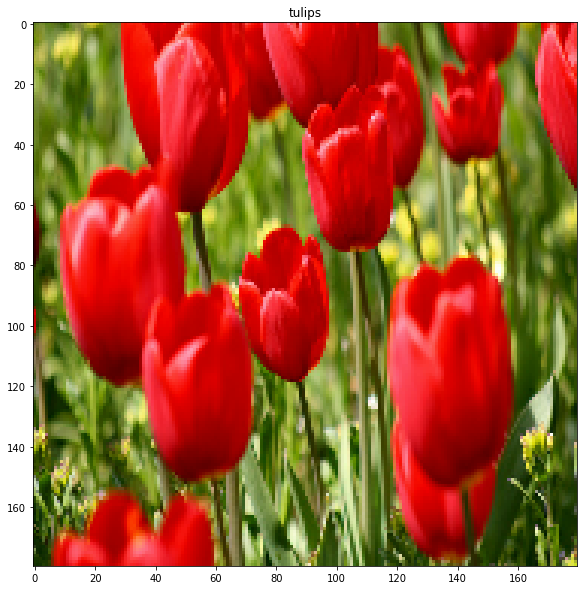

In [25]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential()
resize_and_rescale.add(keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE))
resize_and_rescale.add(keras.layers.experimental.preprocessing.Rescaling(1./255.))

fig = plt.figure(figsize=(10,10))
image = np.nan
for images, labels in train_ds.take(1):
    image = images.numpy().astype('uint8')
    plt.imshow(resize_and_rescale(image))
    plt.title(metadata.features['label'].int2str(labels))

(333, 500, 3)
(1, 333, 500, 3)


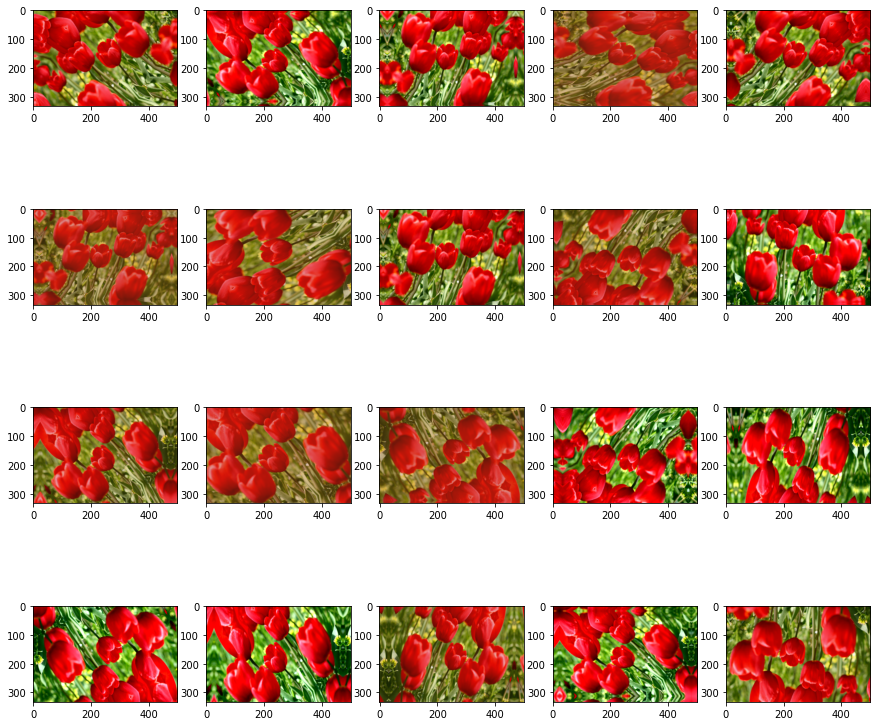

In [26]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(keras.layers.experimental.preprocessing.RandomRotation(0.2))
data_augmentation.add(keras.layers.experimental.preprocessing.RandomZoom(.2, .2))
data_augmentation.add(keras.layers.experimental.preprocessing.RandomContrast(0.4))

print(image.shape)
image = tf.expand_dims(image, 0)
print(image.shape)

fig = plt.figure(figsize=(15,14))
for i in range(20):
    augmented_image = data_augmentation(image)
    fig.add_subplot(4,5, i+1)
    plt.imshow(augmented_image[0])

In [ ]:
## As other method, keras.preprocessing.image.ImageDataGenerator might be useful.
## To increase images, use > datagen.flow(X_train,y_train, batch_size=1024)

'''
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)
'''

# Modeling

In [37]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # optimize performance in parallel processing with num_parallel_calls
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    ds = ds.batch(batch_size)
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [40]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(num_classes))

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs=5

model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
92/92 [==============================] - 59s 620ms/step - loss: 1.6324 - accuracy: 0.3135 - val_loss: 1.2108 - val_accuracy: 0.4877
Epoch 2/5
92/92 [==============================] - 57s 601ms/step - loss: 1.2052 - accuracy: 0.4863 - val_loss: 1.1654 - val_accuracy: 0.5286
Epoch 3/5
92/92 [==============================] - 58s 611ms/step - loss: 1.1013 - accuracy: 0.5727 - val_loss: 1.0057 - val_accuracy: 0.6431
Epoch 4/5
92/92 [==============================] - 56s 599ms/step - loss: 1.0386 - accuracy: 0.5825 - val_loss: 0.9655 - val_accuracy: 0.6185
Epoch 5/5
92/92 [==============================] - 57s 605ms/step - loss: 0.9570 - accuracy: 0.6375 - val_loss: 0.9128 - val_accuracy: 0.6485
